# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 44

**Author 1 (sciper):** Paul Véronique Guillaume DEVIANNE (311030)
**Author 2 (sciper):** Rizhong LIN (366842)

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [2]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Darwin
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [4]:
import torch

# Label mapping
label_to_classname = {0: "TUMOR", 1: "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [5]:
import numpy as np
from sklearn.covariance import LedoitWolf
from scipy.linalg import inv

# Separate features based on class labels
tumor_features = train_features[train_labels == 0]
stroma_features = train_features[train_labels == 1]

# Calculate the mean for each class
tumor_mean = tumor_features.mean(axis=0)
stroma_mean = stroma_features.mean(axis=0)

# Compute the covariance matrices using LedoitWolf
cov_estimator = LedoitWolf()
tumor_cov = cov_estimator.fit(tumor_features).covariance_
stroma_cov = cov_estimator.fit(stroma_features).covariance_


# Function to compute Mahalanobis distance
def mahalanobis_distance(x, mean, cov_inv):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff, cov_inv), diff))


# Precompute inverse of the covariance matrices
tumor_cov_inv = inv(tumor_cov)
stroma_cov_inv = inv(stroma_cov)

# Classify test features
predicted_labels = []
for test_feature in test_features:
    # Compute Mahalanobis distance for each class
    tumor_distance = mahalanobis_distance(test_feature, tumor_mean, tumor_cov_inv)
    stroma_distance = mahalanobis_distance(test_feature, stroma_mean, stroma_cov_inv)

    # Classify based on the minimum distance
    predicted_labels.append(0 if tumor_distance < stroma_distance else 1)

# Convert list to numpy array
predicted_labels = np.array(predicted_labels)

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [6]:
# Compute accuracy
accuracy = np.sum(predicted_labels == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9785


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [7]:
label_to_classname_w_ood = {0: "TUMOR", 1: "STROMA", -1: "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:**

The minimum Mahalanobis distance is a good OoD-ness score, because it measures the similarity of a test sample to the training samples while accounting for the correlations among features. A higher minimum Mahalanobis distance indicates that the test example is far from both TUMOR and STROMA classes in the feature space, making it more likely to be an OoD example. This distance can be used as a metric to distinguish between in-distribution and out-of-distribution samples.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [8]:
# Compute minimum Mahalanobis distance for every test example
min_mahalanobis_distances = []
for test_feature in test_features_w_ood:
    tumor_distance = mahalanobis_distance(test_feature, tumor_mean, tumor_cov_inv)
    stroma_distance = mahalanobis_distance(test_feature, stroma_mean, stroma_cov_inv)
    min_distance = min(tumor_distance, stroma_distance)
    min_mahalanobis_distances.append(min_distance.item())

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

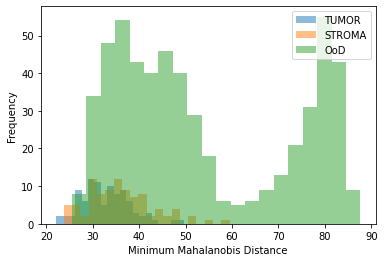

In [9]:
import matplotlib.pyplot as plt

# Separate distances based on class labels
tumor_distances = [min_mahalanobis_distances[i] for i in range(len(test_labels_w_ood)) if test_labels_w_ood[i] == 0]
stroma_distances = [min_mahalanobis_distances[i] for i in range(len(test_labels_w_ood)) if test_labels_w_ood[i] == 1]
ood_distances = [min_mahalanobis_distances[i] for i in range(len(test_labels_w_ood)) if test_labels_w_ood[i] == -1]

# Plot histogram
plt.hist(tumor_distances, bins=20, alpha=0.5, label='TUMOR')
plt.hist(stroma_distances, bins=20, alpha=0.5, label='STROMA')
plt.hist(ood_distances, bins=20, alpha=0.5, label='OoD')
plt.xlabel('Minimum Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observations:**

In the histogram, we can see that the Mahalanobis distances of the OoD tissue types are generally higher than those of the TUMOR and STROMA tissue types. This suggests that the minimum Mahalanobis distance can be used as an OoD-ness score to differentiate between in-distribution and out-of-distribution samples.

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [10]:
threshold = np.percentile(ood_distances, 5)
filtered_tumor = sum(d > threshold for d in tumor_distances)
filtered_stroma = sum(d > threshold for d in stroma_distances)
print(f"Threshold: {threshold:.4f}")
print(f"Filtered TUMOR samples: {filtered_tumor}")
print(f"Filtered STROMA samples: {filtered_stroma}")

Threshold: 30.7695
Filtered TUMOR samples: 57
Filtered STROMA samples: 69


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [11]:
# Assign prediction -1 to filtered out examples
predicted_labels_w_ood = []
for min_distance, test_feature in zip(min_mahalanobis_distances, test_features_w_ood):
    if min_distance > threshold:
        predicted_labels_w_ood.append(-1)
    else:
        tumor_distance = mahalanobis_distance(test_feature, tumor_mean, tumor_cov_inv)
        stroma_distance = mahalanobis_distance(test_feature, stroma_mean, stroma_cov_inv)
        predicted_labels_w_ood.append(0 if tumor_distance < stroma_distance else 1)

# Compute average class-wise accuracy
correct_predictions = 0
total_tumor = sum(test_labels_w_ood == 0)
total_stroma = sum(test_labels_w_ood == 1)
total_ood = sum(test_labels_w_ood == -1)

for pred, true_label in zip(predicted_labels_w_ood, test_labels_w_ood):
    if pred == true_label:
        correct_predictions += 1

accuracy_tumor = sum(np.array(predicted_labels_w_ood)[test_labels_w_ood == 0] == 0) / total_tumor
accuracy_stroma = sum(np.array(predicted_labels_w_ood)[test_labels_w_ood == 1] == 1) / total_stroma
accuracy_ood = sum(np.array(predicted_labels_w_ood)[test_labels_w_ood == -1] == -1) / total_ood

print(f"Class-wise accuracy:")
print(f"TUMOR: {accuracy_tumor:.4f}")
print(f"STROMA: {accuracy_stroma:.4f}")
print(f"OoD: {accuracy_ood:.4f}")

overall_accuracy = correct_predictions / len(test_labels_w_ood)
print(f"\nOverall accuracy: {overall_accuracy:.4f}")

in_distribution_accuracy = (sum(np.array(predicted_labels_w_ood)[test_labels_w_ood == 0] == 0) + sum(np.array(predicted_labels_w_ood)[test_labels_w_ood == 1] == 1)) / (total_tumor + total_stroma)
print(f"In-distribution accuracy: {in_distribution_accuracy:.4f}")

Class-wise accuracy:
TUMOR: 0.3871
STROMA: 0.2581
OoD: 0.9498

Overall accuracy: 0.7930
In-distribution accuracy: 0.3226


We do not find the results to be satisfactory. The overall accuracy stands at 0.79, while the in-distribution accuracy is merely 0.32. This implies that the model is struggling to classify the in-distribution samples accurately, as the threshold is set too low, causing most of the in-distribution samples to be filtered out.

The current approach may result in a high false negative rate, wherein many TUMOR and STROMA samples are discarded as OoD samples, potentially impacting the clinical decision-making process.

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Choose k
k = 5

# Train the k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(train_features, train_labels)

# Make predictions on the test set
knn_predictions = knn_classifier.predict(test_features)

# Calculate the accuracy
knn_accuracy = np.mean(knn_predictions == test_labels)
print(f"Accuracy: {knn_accuracy:.4f}")

Accuracy: 0.9946


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

In [13]:
def compute_classwise_accuracy(predictions, true_labels, label_to_classname):
    classwise_accuracy = {}
    for label in label_to_classname.keys():
        class_indices = np.where(true_labels == label)[0]
        class_predictions = predictions[class_indices]
        class_true_labels = true_labels[class_indices]
        class_accuracy = np.mean(class_predictions == class_true_labels)
        classwise_accuracy[label] = class_accuracy
    return classwise_accuracy


# Compute k-NN distances for every test example
knn_distances = knn_classifier.kneighbors(test_features_w_ood, return_distance=True)[0]

# Compute the average distance to the k-nearest neighbors
avg_knn_distances = np.mean(knn_distances, axis=1)

# Separate distances based on class labels
tumor_distances = [avg_knn_distances[i] for i in range(len(test_labels_w_ood)) if test_labels_w_ood[i] == 0]
stroma_distances = [avg_knn_distances[i] for i in range(len(test_labels_w_ood)) if test_labels_w_ood[i] == 1]
ood_distances = [avg_knn_distances[i] for i in range(len(test_labels_w_ood)) if test_labels_w_ood[i] == -1]

# Find a threshold to filter out 95% of the OoD examples
threshold = np.percentile(ood_distances, 5)

# Filter out examples and compute the average class-wise accuracy
filtered_tumor = sum(d > threshold for d in tumor_distances)
filtered_stroma = sum(d > threshold for d in stroma_distances)
print(f"Threshold: {threshold:.4f}")
print(f"Filtered TUMOR samples: {filtered_tumor}")
print(f"Filtered STROMA samples: {filtered_stroma}")

# Assign prediction -1 to filtered out examples
knn_predictions_w_ood = knn_classifier.predict(test_features_w_ood)
knn_predictions_w_ood[avg_knn_distances > threshold] = -1

# Compute the average class-wise accuracy
class_wise_accuracy = compute_classwise_accuracy(knn_predictions_w_ood, test_labels_w_ood, label_to_classname_w_ood)
print("\nClass-wise accuracy:")
for label, acc in class_wise_accuracy.items():
    print(f"{label_to_classname_w_ood[label]}: {acc:.4f}")

print(f"\nOverall accuracy: {np.mean(knn_predictions_w_ood == test_labels_w_ood):.4f}")
in_distribution_accuracy = (sum(np.array(knn_predictions_w_ood)[test_labels_w_ood == 0] == 0) + sum(np.array(knn_predictions_w_ood)[test_labels_w_ood == 1] == 1)) / (total_tumor + total_stroma)
print(f"In-distribution accuracy: {in_distribution_accuracy:.4f}")

Threshold: 43.8354
Filtered TUMOR samples: 60
Filtered STROMA samples: 45

Class-wise accuracy:
TUMOR: 0.3548
STROMA: 0.5161
OoD: 0.9498

Overall accuracy: 0.8212
In-distribution accuracy: 0.4355


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:**

k-NN can be better than Mahalanobis distance for this problem because it considers local relationships among samples in the feature space, which may capture more complex structures within the data. The Mahalanobis distance, on the other hand, assumes that the data follows a Gaussian distribution, which may not always hold true. Moreover, k-NN can adapt its decision boundaries based on the local density of samples, making it more flexible and robust to noise.

From the accuracy results, we can see that k-NN performs slightly better than Mahalanobis distance.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:**

The approach presented in this exercise might not be optimal for computing the TUMOR/STROMA ratio automatically, mainly due to the following reasons:

1. The accuracy of the classifiers (Mahalanobis distance and k-NN) might not be sufficiently high for clinical decision-making, especially considering the presence of OoD samples that could impact the overall performance of the classifiers.

2. The classifiers may filter out a significant number of TUMOR and STROMA samples, leading to false negatives and inaccurate TUMOR/STROMA ratio estimations.

To improve the presented approach, we can consider the following:

1. **Feature Engineering**: We can try to extract more informative features from the images, which could better represent TUMOR and STROMA tissues and potentially improve the performance of the classifiers. Additional features could also be derived from the existing feature set using dimensionality reduction techniques such as PCA or t-SNE.

2. **Ensemble Methods**: Combining the predictions of multiple classifiers using techniques like bagging or boosting could potentially improve the overall classification performance. This approach can leverage the strengths of different classifiers, thereby reducing the impact of individual classifier weaknesses.

3. **Semi-Supervised Learning**: Since annotating all the training dataset is not an option, we can use semi-supervised learning techniques, such as self-training or co-training, to leverage the information from both labeled and unlabeled data. This may help to improve the classifier's performance, particularly in the presence of OoD samples.

These improvements, if implemented effectively, can lead to a more accurate and reliable computation of the TUMOR/STROMA ratio automatically.


---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [14]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [15]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [16]:
class Sipakmed(Dataset):
    phase_dict = {
        'train': {'start': 0.0, 'stop': 0.5},
        'val': {'start': 0.5, 'stop': 0.75},
        'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1,
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }

    def __init__(self, features_path, phase):
        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase

        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()

    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))

            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]

            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)

        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [17]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, 'train')
val_dataset = Sipakmed(features_path, 'val')
test_dataset = Sipakmed(features_path, 'test')

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 2022
Validation dataset size: 1012
Test dataset size: 1015


Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [18]:
# Define batch size
batch_size = 64

# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Get to know your data. Plot a few example images for each class of your dataset.

Unique labels: [0 1 2 3 4]


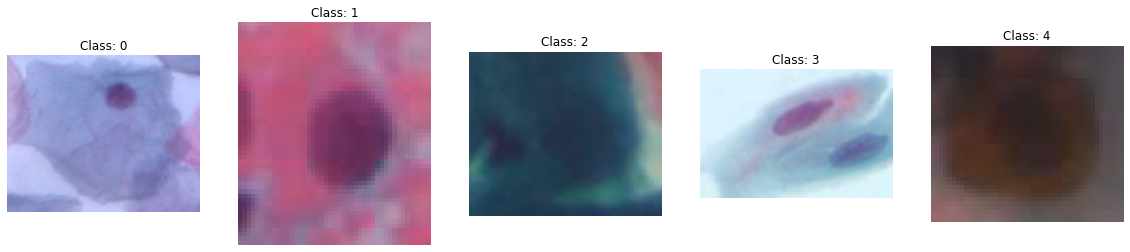

In [19]:
image_path = '../data/lab-03-data/part2/'

# Get all unique labels
unique_labels = np.unique(train_dataset.labels)
print(f'Unique labels: {unique_labels}')

# Get one example per class
fig, axs = plt.subplots(nrows=1, ncols=len(unique_labels), figsize=(20, 5))
for i, label in enumerate(unique_labels):
    # Get the first image with the corresponding label
    image, label, path = [x[0] for x in zip(*filter(lambda x: x[1] == label, train_dataset))]
    path = os.path.join(image_path, path)
    axs[i].imshow(Image.open(path))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')
plt.show()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [20]:
# Implement the model

class ClassifierModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
embedding_dim = train_dataset.features.shape[1]
model = ClassifierModel(embedding_dim, 256, 128, len(unique_labels))

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [21]:
# Set the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)

In [22]:
# Set the loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

criterion = FocalLoss(alpha=1, gamma=2)

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [23]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    acc = 100 * correct / total
    return acc


Implement a function `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [24]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    model.train()

    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, _ = batch

        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)

        # Reset the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Store the outputs, labels and loss
        full_outputs.append(outputs.detach())
        full_labels.append(labels.detach())
        losses.append(loss.detach())

    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()

    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses

Implement a function `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [25]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in evaluation mode
    model.eval()

    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, paths = batch

        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)

        # Store the outputs, labels and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        full_paths.append(paths)
        losses.append(loss)

    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)

    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [26]:
# Main loop
epochs = 20
best_acc = 0
model_savepath = '../data'

for epoch in range(epochs):
    # Train
    train_acc, _, _, train_loss = train(model, optimizer, criterion, train_loader)

    # Evaluate
    val_acc, _, _, val_loss, _ = validate(model, criterion, val_loader)

    # Save the model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_savepath, 'best_model.pth'))

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 2048, 3, 3], but got 2-dimensional input of size [64, 2048] instead

### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [ ]:
# Re-load the best model
best_model_path = os.path.join(model_savepath, 'best_model.pth')
best_model = ClassifierModel(embedding_dim, 256, 128, len(unique_labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.cpu()

# Evaluate
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(best_model, criterion, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}')


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(test_labels, test_outputs.argmax(dim=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(Sipakmed.label_dict.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

In [ ]:
# Find the misclassified samples
misclassified_indices = (test_outputs.argmax(dim=1) != test_labels).nonzero().flatten()
misclassified_paths = test_paths[misclassified_indices]
misclassified_gt = test_labels[misclassified_indices]
misclassified_preds = test_outputs.argmax(dim=1)[misclassified_indices]

# Plot the misclassified samples
image_path = '../data/lab-03-data/part2/'
num_samples_to_show = min(10, len(misclassified_indices))  # You can change this to plot more or fewer samples

fig, axs = plt.subplots(nrows=1, ncols=num_samples_to_show, figsize=(20, 5))
for i in range(num_samples_to_show):
    img_path = os.path.join(image_path, misclassified_paths[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(f'Pred: {misclassified_preds[i]}, GT: {misclassified_gt[i]}')
    axs[i].axis('off')
plt.show()
